In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE  # for imbalance handling

import matplotlib.pyplot as plt
import xgboost as xgb
# ====================== Create a synthetic imbalanced classification dataset ==============
X, y = make_classification(
    n_samples=5000,
    n_features=20,
    n_informative=5,
    n_redundant=2,
    n_clusters_per_class=1,
    weights=[0.9, 0.1],  
    flip_y=0,
    random_state=42
)

# ======================== Introduce missing values randomly in features (simulate missing data) ================
rng = np.random.default_rng(42)
missing_rate = 0.1  # 10% missing values
missing_mask = rng.random(X.shape) < missing_rate
X[missing_mask] = np.nan




In [4]:
# ==================  Put data into a DataFrame for easier manipulation ==============================
df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
df['target'] = y

# ======================== Handle missing data ============================
# Simple imputation strategy: fill missing values with median of each column
for col in df.columns[:-1]:  # exclude target column
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

# ==================Separate features and target after imputation ===========================
X_imputed = df.drop('target', axis=1).values
y = df['target'].values



/var/folders/vk/hqmx8gw16vd_vkfc0x219kb80000gn/T/ipykernel_44457/2810255974.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


In [5]:
# ============================ Split dataset into train and test sets (stratify to keep class ratio)==================
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# ======================= Handle imbalance using SMOTE (Synthetic Minority Over-sampling Technique)====================
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original training set class distribution: {np.bincount(y_train)}")
print(f"Balanced training set class distribution: {np.bincount(y_train_balanced)}")

# ========================= Define the XGBoost classifier with parameters tuned for imbalance ================
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    scale_pos_weight=1,  
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)



Original training set class distribution: [3150  350]
Balanced training set class distribution: [3150 3150]


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:12:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[1311   39]
 [  22  128]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1350
           1       0.77      0.85      0.81       150

    accuracy                           0.96      1500
   macro avg       0.87      0.91      0.89      1500
weighted avg       0.96      0.96      0.96      1500

ROC AUC Score: 0.9808


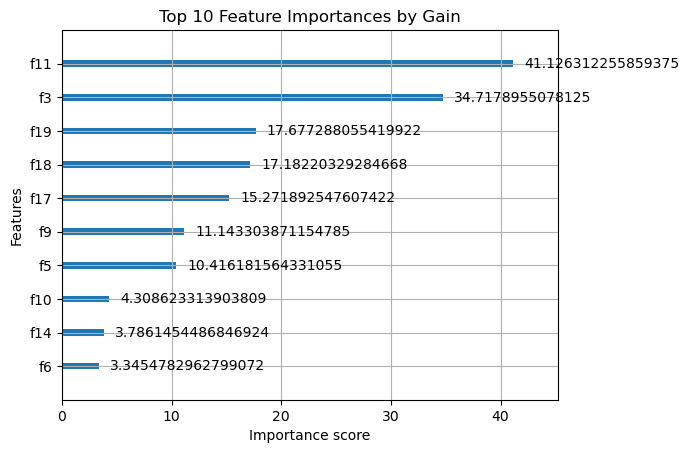

In [6]:
# ========================= Train the model on balanced data ==============
model.fit(X_train_balanced, y_train_balanced)

# ========================  Make predictions on test set ==================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# =================  Evaluate the model 
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {auc_score:.4f}")



xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances by Gain")
plt.show()